# Lab2: Simple Recurrent Network Models for Experimental Predictions
#### Jennifer Spenader, Giorgos Tziafas, 2020

## Learning Goals for this lab:

* Extend practical skills in using Python and Keras to implement simple recurrent networks
* Understand the motivations for the second simulation study in the Mirman, Graf Estes and Magnuson (2010) paper
* Implement the simulation architecture and run the simulation
* Extend knowledge by further building a simulation for the Misyak, Christiansen and Tomblin (2009) study
* Confirm the findings of the two papers by performing a new single reaction experiment with new data
* Reflect on whether you think the model predictions are realisting enough for human participants or not

**Note:** only questions next to capital letters in `Exercise` sections need to be included in the report. Other questions are rhetorical.

# Part 1: Recreating Mirman et al.

Let's first focus on these second model in the Mirman, Graf Estes and Magnuson paper. To really understand this you should carefully read the paper, in particular page 4 and pages 9-11. First, make sure you understand what the model is trying to show. Answer the following questions:

## Exercise 1

 A) The Mirman et al. paper wants to find evidence linking statistical learning with word learning. In your own words, summarize briefly (but using precise terms) what results with human subjects (adults and children) are the trying to explain better?

*Answer*
 
 
 The paper (Mirman et al.) examines how Simple Recurrent Networks(SRNs) may be used to model human language learning skills and dgenerates new insights into the process of language learning. In order to test their learning capabilities, SRN architectures were used to model two experiments (that were performed with human participants in Mirman et al., 2008):
 
 * Simulation 1: The SRN model tested learners' sensitivity to syllable transitional probabilities vs frequency patterns.
 * Simulation 2: The SRN model tested the hypothesis that learners benefit from transitional probability information to support label learning.
 
 The 

 B) What does Simulation 2 actually show?
 
 *Answer*
 
 Experiment 1 demonstrates that adult participants tend to learn novel object labels faster when labels contain high probability syllable transitions. Experiment 2 expanded on Experiment 1, examining the relation between the difference in learning of high probability and low probability syllable transitions and the facilitative or inhibitive nature of these syllable transitions. This was done by introducing the participants to a set of "nonwords" which were composed of syllables that participants were not exposed to during the exposure phase.
 
 The results depict that there is a relationship between the statistical segmentation and word learning, but in contrast to the behaviour observed in infants, adults learned high transitional probability utterances and non-occuring utterances more quickly.

 C) Explain briefly in what way do the results of Simulation 2 add to or clarify the human results.

## Model and data files

All the simulation data files can be found on Nestor under a folder named `Mirman_Sim`. (These are the ACTUAL files that the authors used for their paper implementation in Lens!). However, since the purpose of this lab is for you to recreate their simulation in Python, we have provided you with the necessary utilities for parsing the origina data. Just for reference, here are some of the key files with descriptions of their contents:
* `exposureSet2Syll35.ex`: Training examples for the exposure phase 
* `labelSet2SyllW35.ex`: Set of 'Words' for the label learning phase
* `labelSet2SyllPW35.ex`: Set of 'Part Words' for the label learning phase
* `labelSet2SyllNW35.ex`: Set of 'Non-Words'
* `labelSet2SyllNWc35.ex` : Another set of 'Non-Words'

Let's first import all of our necessary utilities for this lab: The `tensorflow.keras` modules for implementing and training our SRNs, some generic Python modules as well as the aforementioned lab utilities from the `mirman_utils.py` script that you can also find in Nestor under `Lab2`. The `LensParser` class takes care of parsing the input data from the Lens format to Python lists and the `Binarizer` class transforms these data to binary `numpy` vectors for interfacing with `keras`.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, TimeDistributed, Flatten
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import SGD

import random
import numpy as np 

from matplotlib import pyplot as plt 

from mirman_utils import LensParser, Binarizer, multi_plot

/Users/varunravivarma/py3_virtualenv/jupe/lib/python3.7/site-packages/pydot.py:18: UserWarning: Couldn't import dot_parser, loading of dot files will not be possible.


The Mirman simulation consists of two phases. First, in the *exposure phase*, the model is presented with 1000-syllable sequences. Our recurrent network takes as an input the first syllable (encoded as a one-hot vector representation) and predicts the next syllable (again encoded as a one-hot vector). The second syllable of the word is then the second input and the third syllable is predicted, etc. Does this model look similar to you as the one that Elman used for lexical class learning? In what ways? The purpose of this phase is to simulate the exposure of human subjects to statistical dependencies between syllables of words in an artificial language.

After the exposure phase, the model is trained on a *label learning* task. The purpose is for our model to activate one out of 5 unique "object" labels after presented with a two-syllable word. This phase simulates the potential of human subjects in learning to map new words to their object representations in the world. Four different label categories, including different overlapping syllable dependencies with the exposure phase are included in order to further research the connection between this statistical learning and word learning. In other words, the research question at hand is whether an SRN that is trained to predict labels for words consisting of syllable transitions never encountered before (or encountered with smaller probabilities) follows the same behaviour in learning them as human subjects do.


After reading the paper fill the code below to define the Mirman SRN model.

**Note:** Even though in the paper implementation it is explicitely said that the output consists of 15 neurons (the first 10 are for what and the second 5 for what?) in order to follow the traditional `keras` flow and keep things simple we need to define our model's output as 20, the same as the input, even though our model will learn never to activate the last 5.

In [5]:
## fillin _ with the correct parameter 
model = Sequential([
    SimpleRNN(15, input_shape=(None, 20),
              return_sequences=True,
              activation='tanh',
              name='hidden'),
    TimeDistributed(Dense(20, activation='softmax', name='output'))
])

model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=0.03, momentum=0.9),
              metrics=['categorical_accuracy', 'mean_squared_error'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (SimpleRNN)           (None, None, 15)          540       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 20)          320       
Total params: 860
Trainable params: 860
Non-trainable params: 0
_________________________________________________________________
None


## Exercise 2

A) Take a look at the provided Lens file for the exposure phase data. In the Lens format, the syllables are abstract sequences of node activations, with an integer representing the bit of the one-hot encoding that is activated, with each set of two input-output ('I' and 'T') pairs treated as a single 2-syllable word, e.g:
   
    name: {1_0} 2
    I: {  1} 3
    T: {  1} 7 
    I: {  1} 7 
    T: {  1} 1
    ;
   
In this example, the current word consists of the $[3,7]$ syllables (out of the 10 used for exposure phase) and the first syllable of the next word is $1$. There are $1000$ such examples of syllable transitions in this file. Explain how this number is arrived at given the Lens format.

 *Answer*
 The model recieves one syllable as input at the starting of exposure. The target is then the next syllable. When the second syllable is presented to the network, the target is then the third syllable. Thus, given a syllable, the model aims to predict the subsequent two syllables in the 3 syllable label.
 
 In case of the example, the the predictions are generated by the model in the following manner:
 
 $3 \to 7 $ followed by $7 \to 1$
 
 The exposure file is used to teach the model the underlying probability distributions for words, part-words and non-words. 

B) Do the same for the provided label learning data files. In each such file, the same format is used, but for defining the 5 different two-syllable words that the network must learn to distinguish. These are just the description of the labels and not the training data themselves. For example in the word data file:
 
     name: {4} 2
     I: {  1} 4 
     T: {  1} 13
     I: {  1} 9 
     T: {  1} 13
     ;
     
This block tells us that the 2-syllable word $[4,9]$ should be mapped to label $13$. Give the set of all different labels in all such files. What does this set have to do with our network's output activations? 
 
 
 

C) Out of the two non-word data files, one contains novel-sequence non-words (syllable transitions never encountered in the exposure phase) and one novel-syllable non-words (new syllables). Which one is which? How can you tell?

## Exposure Phase

Now that you've understood how our data is structured, let's implement the exposure phase of our simulation! First, use the `parse_sequence` method of the provided parser to parse the Lens files into Python lists. Inspect the data to verify you understand their structure compared to the Lens format. In order to convert our data to vector representations, we will define a `Binarizer` object and make use of the `binarize_sequence` method. Inspect the data shape and contents.

In [3]:
parser = LensParser()
bnzer = Binarizer(vocab_size=20)

exposure_data = parser.parse_sequence('./exposureSet2Syll35.ex')

# inspect the first 10 tokens of the sequence
print(exposure_data[:10])

X_exposure, y_exposure = bnzer.binarize_sequence(exposure_data)

# inspect one-hot representations. Everything looks fine?
print(X_exposure.shape, y_exposure.shape)
print('-' * 48)
print(X_exposure[:,:10])
print('-' * 48)
print(y_exposure[:,:10])

[6, 0, 3, 7, 1, 2, 4, 9, 8, 5]
(1, 1000, 20) (1, 1000, 20)
------------------------------------------------
[[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]]
------------------------------------------------
[[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 

Now that our model and data are in place, you are ready to simulate the exposure phase!
(**Note:** When attempting to re-train your model remember to run the model definition cell again in order to re-initialize it, otherwise you are training on top of your previous weights!)

Train on 1 samples
Epoch 1/75
1/1 - 1s - loss: 3.0783 - categorical_accuracy: 0.0330 - mean_squared_error: 0.0480
Epoch 2/75
1/1 - 0s - loss: 3.0565 - categorical_accuracy: 0.0360 - mean_squared_error: 0.0478
Epoch 3/75
1/1 - 0s - loss: 3.0180 - categorical_accuracy: 0.0400 - mean_squared_error: 0.0477
Epoch 4/75
1/1 - 0s - loss: 2.9672 - categorical_accuracy: 0.0560 - mean_squared_error: 0.0474
Epoch 5/75
1/1 - 0s - loss: 2.9076 - categorical_accuracy: 0.0890 - mean_squared_error: 0.0471
Epoch 6/75
1/1 - 0s - loss: 2.8413 - categorical_accuracy: 0.1210 - mean_squared_error: 0.0467
Epoch 7/75
1/1 - 0s - loss: 2.7698 - categorical_accuracy: 0.1680 - mean_squared_error: 0.0463
Epoch 8/75
1/1 - 0s - loss: 2.6946 - categorical_accuracy: 0.2060 - mean_squared_error: 0.0459
Epoch 9/75
1/1 - 0s - loss: 2.6179 - categorical_accuracy: 0.2430 - mean_squared_error: 0.0454
Epoch 10/75
1/1 - 0s - loss: 2.5422 - categorical_accuracy: 0.2830 - mean_squared_error: 0.0449
Epoch 11/75
1/1 - 0s - loss: 2

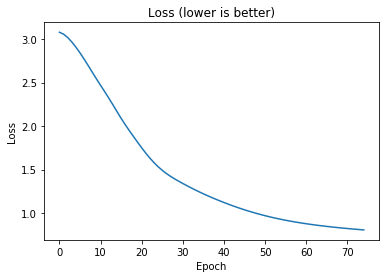

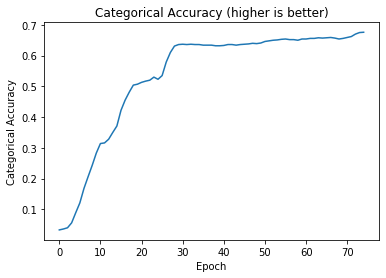

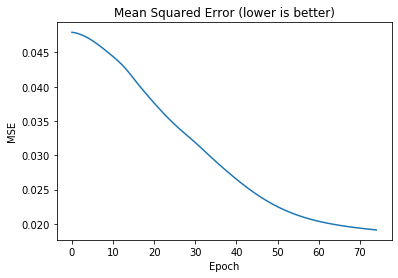

In [4]:
exposure_phase = model.fit(X_exposure, y_exposure, epochs=75, verbose=2)

plt.plot(exposure_phase.history['loss'])
plt.title('Loss (lower is better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(exposure_phase.history['categorical_accuracy'])
plt.title('Categorical Accuracy (higher is better)')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(exposure_phase.history['mean_squared_error'])
plt.title('Mean Squared Error (lower is better)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

postexposure_weights = model.get_weights()

## Exercise 3

 A) Train multiple times and average your results. How much training is needed to get a low error rate? (include an example graph in your report)
 
 B) How much training did they report in the paper? Would half this training be sufficient? Experiment and explain your results.

## Label Learning Phase

For the label learning phase, we will have to further train our model 4 times, once for every different category of label learning data (word, part-word, novel-syllable non-word and novel-sequence non-word). We will use the `parse_labels` method of our parser to obtain our 5 2-syllable label words. Inspect them to make sure you understand the data format. We then sample 100 examples from such words and binarize. Do our data shapes seem logical?

In [ ]:
# load words label data for label learning phase
word_labels = parser.parse_labels('./labelSet2SyllW35.ex')

# inspect the data. Are they the same as in the input files?
print('Word labels={}'.format(word_labels))

# generate 100 training word examples
word_data = random.choices(word_labels, k=100)
print('First 5 word label examples={}'.format(word_data[:5]))

# convert to one-hot encodings
Xw, yw = bnzer.binarize_labels(word_data)

# inspect the input data shape. Make sense?
print('Word data shape={}, labels shape={}'.format(Xw.shape, yw.shape))

Without re-initializing our model (keeping the weights the same as after the exposure phase) we are ready to further train it for the label learning task!

In [ ]:
model.set_weights(postexposure_weights)
words_learning = model.fit(Xw, yw, epochs=100, verbose=2)

plt.plot(words_learning.history['loss'])
plt.title('Loss (lower is better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(words_learning.history['categorical_accuracy'])
plt.title('Categorical Accuracy (higher is better)')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(words_learning.history['mean_squared_error'])
plt.title('Mean Squared Error (lower is better)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

Repeat this process for the other 3 label categories. 

In [ ]:
# repeat for the other 3 categories. Don't forget to set the model back to it's postexposure phase!

## implement your code here! ##

part_words_learning = model.fit()
non_words_learning = model.fit()
non_words_c_learning = model.fit()

Then, use the provided `multi_plot` function to compare the learning progress of the four different categories. (**Note:** You might want to take several trials of the four learning steps in order to gain serious insight about the results)

In [ ]:
losses = [words_learning.history['loss'], part_words_learning.history['loss'], \
          non_words_learning.history['loss'], non_words_c_learning.history['loss']]

accuracies = [words_learning.history['categorical_accuracy'], \
              part_words_learning.history['categorical_accuracy'], \
              non_words_learning.history['categorical_accuracy'], \
              non_words_c_learning.history['categorical_accuracy']]


MSEs = [words_learning.history['mean_squared_error'], \
        part_words_learning.history['mean_squared_error'], \
        non_words_learning.history['mean_squared_error'], \
        non_words_c_learning.history['mean_squared_error']]


multi_plot(losses, accuracies, MSEs)

## Exercise 4

 A) Why do we need to include novel-syllable nonwords in the simulation? What purpose does it serve?
 
 B) In the label learning phase, our model must be initialized with the postexposure weights. Explain why. 
 
 C) Report your comparison graph for the different label categories. Do you obtain similar results as those reported in the paper? Discuss any differences.
 
 D) Given the distincion between adult-child results in the human experiments and your model's results, would you say that your SRN model is simulating children or adults? Explain your answer.

# Part 2: Modelling Misyak et al. (2010)
Read Misyak, Christiansen and Tomblin (2010). On page 139 you can find information about the human experiments and on page 145 the description of the SRN employed and the constructed training examples.

## Model and training data
Make sure you understand the experiment details, as you will have to create your own data for simulating it. The data in our case are strings consisting of 3 nonword tokens; A starting nonword syllable ($a$, $b$ or $c$), a middle bisyllabic nonword $X_1,...,X_{24}$ and an ending token ($d$, $e$ or $f$). What combinations are considered *grammatical* in the paper? The purpose of this simulation is to investigate whether the SRN model can learn to predict the ending token of each string after being exposed to the grammatical dependencies for several examples. 

In [ ]:
import itertools

all_tokens = [
 'pel',
 'dak',
 'vot',
 'rid',
 'jic',
 'tood',
 'wadim',
 'kicey',
 'puser',
 'fengle',
 'coomo',
 'loga',
 'gople',
 'taspu',
 'hiftam',
 'deecha',
 'vamey',
 'skiger',
 'benez',
 'gensim',
 'feenam',
 'laelijeen',
 'chila',
 'roosa',
 'plizet',
 'balip',
 'malsig',
 'suleb',
 'nilbo',
 'wiffle'
]

start_tokens = all_tokens[:3]  ## {a,b,c}
end_tokens = all_tokens[3:6]   ## {d,e,f}
middle_tokens = all_tokens[6:] ## {X1,...,X24}

grammar_map = {
    'pel' : 'rid',   ## a->d
    'dak' : 'jic',   ## b->e
    'vot' : 'tood'   ## c->f
}

As described in the paper, the simulation consists of three learning phases:
  * **Phase 1:** During this phase the model is presented with 6 grammatical blocks, each consisting of 72 *unique* strings containing all middle tokens. During this phase we expect the model to learn the inehrent dependencies present in our training exaxmples.
  * **Phase 2:** In the second phase the model is presented with 1 ungrammatical block containing 24 strings of all middle tokens with violated dependencies. This is meant to simulate the disruption in the predictive capacity of human subjects.
  * **Phase 3:** During this "recovery" phase, the model is presented again with 1 grammatical block like that of the first phase.  

The code below will provide you with all unique combinations of the $24$ middle tokens that hold the defined grammatic dependencies for each grammatical block: 

In [ ]:
def generate_grammatical_block():
    return [(*r, grammar_map[r[0]]) for r in itertools.product(start_tokens, middle_tokens)]

# let's inspect a generated block. Does it look grammatical according to the paper? 
print(generate_grammatical_block())

Fill the code snippet below to generate ungrammatical blocks of 24 strings for the second phase of our simulation. (***Hint:*** Dependencies now should like $aXe, aXf, bXd, bXf, cXd$ and $cXe$)

In [ ]:
non_grammar_map = {
    'pel' : ['jic', 'tood'],
    'dak' : ['rid', 'tood'],
    'vot' : ['rid', 'jic']
}

def generate_ungrammatical_block(num_strings=24):
    NotImplemented

# inspect an ungrammatical block. 
print(generate_ungrammatical_block())

In our simulation, as we are employing neural network models, all of our data need to be in continuous form. As a result, we will need to encode our vocabulary $\{a,b,c,d,e,f,X_1,...,X_{24}\}$ into vector representations. What is the size of our vocabulary? Then each nonword syllable or bisyllable should be mapped to a one-hot encoded vector of such size with a one in the index of the present syllable.

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# generate one grammatical block of 72 strings, one ungrammatical of default 24 strings
# and one "recovery" block of 72 grammatical strings
gram_block = random.sample(generate_grammatical_block(), 72)
ungr_block = random.sample(generate_ungrammatical_block(), 24)
rec_block = random.sample(generate_grammatical_block(), 72)

# define an one-hot encoder
encoder = LabelBinarizer()
encoder.fit(all_tokens)

# flatten the strings and transform all tokens to one-hot vectors
gram_tokens = [token for tokens in gram_block for token in tokens]
ungr_tokens = [token for tokens in ungr_block for token in tokens]
rec_tokens = [token for tokens in rec_block for token in tokens]

gram_vectors = encoder.transform(gram_tokens)
ungr_vectors = encoder.transform(ungr_tokens)
rec_vectors = encoder.transform(rec_tokens)

# define training data and targets by shifting the sequence one token to the left 
X_gram = gram_vectors[np.newaxis, :]
y_gram = np.append(gram_vectors[1:], gram_vectors[:1], axis=0)[np.newaxis, :]

X_ungr = ungr_vectors[np.newaxis, :]
y_ungr = np.append(ungr_vectors[1:], ungr_vectors[:1], axis=0)[np.newaxis, :]

X_rec = rec_vectors[np.newaxis, :]
y_rec = np.append(rec_vectors[1:], rec_vectors[:1], axis=0)[np.newaxis, :]

# what is the shape of our data? Does this match descriptions in the paper?
print(X_gram.shape, y_gram.shape, X_ungr.shape, y_ungr.shape, X_rec.shape, y_rec.shape)


Right! Now to our model. By now, you should be experienced in defining SRNs. Read the description of the network parameters from the paper and fill the code below to define the simulation model. You might want to take a look at the Elman implementation from Lab 1 if unsure as to which should be the shape of input/output. 

In [ ]:
## fillin _ with the correct parameter 
model = Sequential([
    SimpleRNN(_, input_shape=(None, _),
              return_sequences=_,
              activation=_,
              recurrent_initializer=_,
              name='hidden'),
    TimeDistributed(Dense(_, activation=_, name='output'))
])

model.compile(loss=_, 
              optimizer=SGD(lr=_, momentum=_),
              metrics=['categorical_accuracy', 'mean_squared_error'])

print(model.summary())

## Simulating the Three Learning Phases 
Run the three learning phases in order and plot your results. Instead of training our model a single epoch in each block, we scale it up to further smooth the learning process and provide better visualization insight.

In [ ]:
scale_factor = 5

print('-'*100)
print('Phase 1: 6 grammatical blocks of 72 strings..\n')
phase_1 = model.fit(X_gram, y_gram, epochs=6*scale_factor, verbose=2)
print('-'*100)

print('Phase 2: 1 ungrammatical block of 24 strings..\n') 
phase_2 = model.fit(X_ungr, y_ungr, epochs=1*scale_factor, verbose=2)
print('-'*100)

print('Phase 3: 1 recovery block of 72 strings..\n')
phase_3 = model.fit(X_rec, y_rec, epochs=1*scale_factor, verbose=2)
print('-'*100)

Make use of the `loss`, `categorical_accuracy` and `mean_squarred_error` keys of the the three phases history dictionaries (e.g. `phase_1.history` for phase 1) to plot the learning progress of the model in our simulation in a single plot.

In [ ]:
import matplotlib.pyplot as plt

loss = phase_1.history['loss'] + phase_2.history['loss'] + phase_3.history['loss'] 
accu = phase_1.history['categorical_accuracy'] + phase_2.history['categorical_accuracy'] \
          + phase_3.history['categorical_accuracy']
mse = phase_1.history['mean_squared_error'] + phase_2.history['mean_squared_error'] \
          + phase_3.history['mean_squared_error']


plt.plot(loss)
plt.title('Loss (lower is better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(accu)
plt.title('Categorical Accuracy (higher is better)')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(mse)
plt.title('Mean Squared Error (lower is better)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

## Prediction Task and  Network Analysis
For the last phase of the simulation, we must inspect whether the model is indeed capable of predicting the last token for 12 grammatical strings. 

In [ ]:
pred_block = random.sample(generate_grammatical_block(), 12)

# lets view our 12 prediction strings
print(pred_block)

In order to know what exactly our model predicts, we will create a sequence consisting of all $12*3=36$ tokens in the prediction block and pass it to our model for inference. We use our one-hot encoder to decode the softmax model predictions back to the original token strings for inspection:

In [ ]:
# convert data to one-hot vectors and make model predictions
pred_tokens = [token for tokens in pred_block for token in tokens]
pred_vectors = encoder.transform(pred_tokens)
X_pred = pred_vectors[np.newaxis, :]

# decode and inspect
predictions = encoder.inverse_transform(np.array(model.predict(X_pred)[0]))

print('12-item prediction task input tokens:\n{}'.format(pred_tokens))
print('\n12-item prediction task output predictions:\n{}'.format(predictions))

Inspect the predictions of the model. Is it indeed able to correctly infer the ending syllable token after seeing the starting and the middle ones? What percentage of the 12 strings were correctly classified? Is this close to your resulting accuracy in your model? You can also make use of the visualization utilities implemented for Lab 1 to inspect the state of our SRN for the Misyak et al. simulation. (Remember to copy paste the necessary python files `plot_functions.py` and `utils.py` to your current working directory)

In [ ]:
from plot_functions import plot_activation_matrix

plt.figure(figsize=(10,8))
plot_activation_matrix(model, X_gram, layers=[model.layers[1]],
                       subset=(0, slice(0, 20), slice(None)),
                       show_values=False)

## Exercise 5
  A) How many weight parameters does the SRN model have in total? How many for the hidden, context and dense layers separately?
  
  B) What is the loss function that you utilize for training the model. What are the evaluation metrics? Do these numbers represent in their absolute value how well the model is able to predict the end token for each string? Explain your answer.
  
  C) How does learning proceed? Include in your report information (table/plot) about the error metrics after each block and at the end of the training. Do you see the effect of the 24 ungrammatical trials in the error? How does learning in the recovery period proceed? Briefly but precisely, describe how it went.
  
  D) In the Misyak et al. study they took the mean score after 30 runs with different random weight initilization. What was the purpose of this? (What does it simulate?)
  
  E) For the 12-item predictiont task, Misyak et al. calculated the Luce ratio difference scores to determine the network's selection. Do this calculation for the 12-item prediction task and include it in your report.

## Part 3: Extending Misyak et al.
Now that you have recreated the simulation from the Misyak et al. paper, you are ready to extend it. What would happen if instead of one word, there were two words in the middle position? Using the same network (don't add addtional hidden layers!) create new training data that differ from the original by having two words in the middle position. Run the new simulation.

## Exercise 6
 
 A) How does learning proceed now? Describe learning, how the error metrics develop (especially after blocks 6,7 and 8).
 
 B) Compare the prediction capacity of the model in this extended simulation to the one of the previous section, commenting on similarities and differences.
 
 C) SRNs with only one context layer can learn more than just one step back in time. But is your SRN successful in this task? Explain your answer.
 
 D) What do you predict human subjects will do, based on the results of your simulation?